In [1]:
import pandas as pd
data = pd.read_csv('/home/jbar/EURUSD15.csv', delimiter='\t', names='Time	Open	High	Low	Close	Volume	Spread'.split())

import numpy as np
np.set_printoptions(suppress=True)

In [2]:
data.head()

,Time,Open,High,Low,Close,Volume,Spread
0,2020-01-13 14:00,1.11187,1.11218,1.11176,1.11208,2161,NaN
1,2020-01-13 14:15,1.11211,1.11227,1.11175,1.11204,2736,NaN
2,2020-01-13 14:30,1.11205,1.11267,1.11204,1.11211,3655,NaN
3,2020-01-13 14:45,1.11211,1.11247,1.11200,1.11240,2959,NaN
4,2020-01-13 15:00,1.11239,1.11268,1.11210,1.11252,2656,NaN


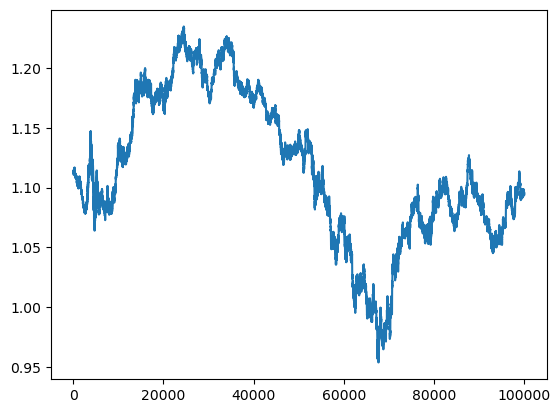

In [3]:
import matplotlib.pyplot as plt
timeseries = data['Close'].values
plt.plot(timeseries)

tensor([1.1121, 1.1120, 1.1121,  ..., 1.1785, 1.1790, 1.1792])
tensor([-3.9935e-05,  6.9976e-05,  2.9004e-04,  ...,  1.1003e-04,
         5.3000e-04,  1.4997e-04])


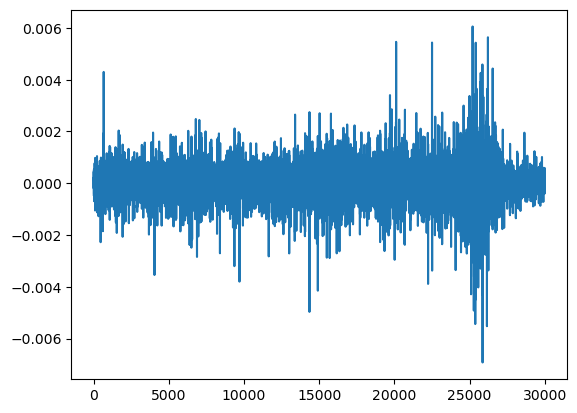

In [42]:
import torch

# Extract data

prices = torch.Tensor(data['Close'].values)[:100000]
print(prices)
print(prices.diff())
gains = prices.diff().div(prices[:-1]).flip(0)
plt.plot(gains)

tensor(2.0832e-06) tensor(0.0005)
tensor([ 0.2446,  0.8752,  0.1785,  ...,  0.5058,  0.1189, -0.0743])


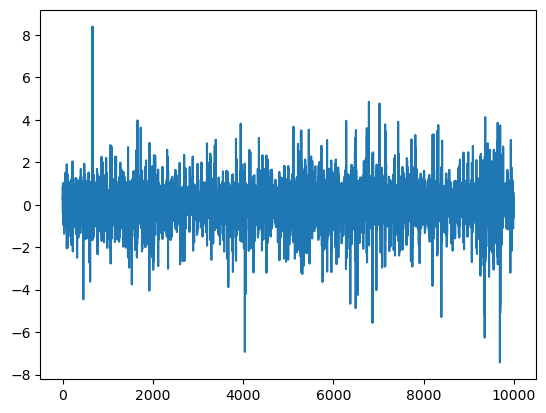

In [43]:
std, mean = torch.std_mean(gains)
print(mean, std)
gains_norm = (gains - mean) / std
print(gains_norm)
plt.plot(gains_norm[:10000])


In [44]:
# Define batches and loader

WINDOW_SIZE = 24
INPUT_SIZE = WINDOW_SIZE - 1
timeseries = gains_norm.unfold(0, WINDOW_SIZE, 1)
train_size = int(timeseries.shape[0] * 0.33)
test_size = timeseries.shape[0] - train_size
train_set, test_set = torch.utils.data.random_split(timeseries, [train_size, test_size])

# optimize this
x_train = torch.stack([sample[:INPUT_SIZE] for sample in train_set])
y_train = torch.stack([sample[INPUT_SIZE:] for sample in train_set])
x_test = torch.stack([sample[:INPUT_SIZE] for sample in test_set])
y_test = torch.stack([sample[INPUT_SIZE:] for sample in test_set])


loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=None, batch_sampler=None, shuffle=True, collate_fn=lambda sample: (sample[:INPUT_SIZE], sample[INPUT_SIZE:]))
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), shuffle=True, batch_size=1)
print(next(iter(loader)))
print(next(iter(loader)))

[tensor([[ 1.2362,  0.1942,  3.0105, -0.0870,  1.3052, -0.3189,  1.3059,  0.5931,
          1.4733, -0.3028, -2.5897,  2.9174, -1.5963, -1.1478,  1.0242, -2.3068,
          1.6207,  0.8420,  1.6226,  3.0885,  0.9609,  1.6607, -1.0191]]), tensor([[-0.0541]])]
[tensor([[-0.6808, -0.1822,  0.3700, -0.0041, -0.2535, -0.6449,  0.9755,  0.0851,
          0.0492, -0.3779, -0.7695, -0.9649, -1.9238,  0.5294, -0.4130, -0.5726,
          0.1559, -0.3951, -0.0041,  0.0671,  0.3158, -0.2530,  0.4582]]), tensor([[-0.1286]])]


In [45]:
import torch
import torch.nn as nn

HIDDEN_SIZE = 64
class EquityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=1, batch_first=False)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [46]:
model = EquityModel()
idx = 532
model(train_set[idx].unsqueeze(0)[:INPUT_SIZE]), train_set[idx][INPUT_SIZE:]

(tensor([[-0.0667]], grad_fn=<AddmmBackward0>), tensor([-0.0041]))

In [47]:
import numpy as np
def money_loss(output, target):
    mov_output, mov_target = output.sum(axis=-1), target.sum(axis=-1)
    # print(mov_output, mov_target)
    exponent = torch.sigmoid(mov_output * mov_target) * torch.pow(mov_target, 2) * 2 - 1
    return torch.pow(2, - exponent).sum()
    # return torch.pow(2, - torch.sign(output.sum(axis=-1)) * torch.sign(target.sum(axis=-1)) * torch.abs(target.sum(axis=-1))).sum()
a, b = torch.Tensor([[1, 1]]), torch.Tensor([[-2, -8]])
money_loss(a, b)

tensor(2.0000)

In [48]:
BATCH_SIZE = 64
model = EquityModel()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = money_loss
# loss_fn = nn.MSELoss()

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        # print(y_pred, y_train)
        # print(y_pred.sum(), y_train.sum())
        train_rmse = loss_fn(y_pred, y_train)
        # print(train_rmse)
        y_pred = model(x_test)
        test_rmse = loss_fn(y_pred, y_test)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 14784.1953, test RMSE 30100.3086
Epoch 1: train RMSE 14776.8848, test RMSE 30092.5957
Epoch 2: train RMSE 14774.2412, test RMSE 30092.3340
Epoch 3: train RMSE 14769.6973, test RMSE 30098.4121
Epoch 4: train RMSE 14765.3945, test RMSE 30103.2754
Epoch 5: train RMSE 14760.3457, test RMSE 30108.9727
Epoch 6: train RMSE 14754.7217, test RMSE 30113.6719
Epoch 7: train RMSE 14747.7578, test RMSE 30119.1094
Epoch 8: train RMSE 14739.7129, test RMSE 30129.9102
Epoch 9: train RMSE 14733.1963, test RMSE 30152.1484
Epoch 10: train RMSE 14721.9561, test RMSE 30170.0391
Epoch 11: train RMSE 14715.1270, test RMSE 30192.6641
Epoch 12: train RMSE 14704.7764, test RMSE 30211.2480
Epoch 13: train RMSE 14696.3086, test RMSE 30234.5332
Epoch 14: train RMSE 14687.3994, test RMSE 30262.1504
Epoch 15: train RMSE 14680.4277, test RMSE 30292.4395
Epoch 16: train RMSE 14671.2031, test RMSE 30314.1504
Epoch 17: train RMSE 14663.5879, test RMSE 30336.5000
Epoch 18: train RMSE 14653.5918, test 

KeyboardInterrupt: 